This code will take in raw text files from wavedump, extract some key parameters, and create an RDataFrame which will be saved as a root file.

## Importing the data

For simplicity, let's use pandas to create a data frame of events from the raw text files.

I will assume your data is kept in an $DATA_DIR specified in your rc file.

In [2]:
import pandas as pd
import os   #for getenv
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = os.getenv("DATA_DIR") + "set2/27/"

print(DATA_DIR)

/home/agcheyne/Code/EIC/MCPtest/data/set2/27/


In [3]:
def read_file (filename):
    events = {}

    with open(filename, 'r') as file:
        while True:
            # Read headers
            header_lines = [file.readline().strip() for _ in range(8)]
            if not header_lines[0]:
                break

            # Extract the header information
            record_length = int(header_lines[0].split(":")[1])
            board_id = int(header_lines[1].split(":")[1])
            event_number = int(header_lines[3].split(":")[1])
            if event_number == 0: # Because for some reason it changes after 1st event.
                channel = str(str(header_lines[2].split(":")[1].strip()))
            else:
                channel = channel 
            pattern = int(header_lines[4].split(":")[1], 16)
            trigger_time_stamp = int(header_lines[5].split(":")[1])
            dc_offset = int(header_lines[6].split(":")[1], 16)
            start_index_cell = int(header_lines[7].split(":")[1])

            # Read the sample points
            samples = []
            for _ in range(record_length):
                sample = file.readline().strip()
                if sample:
                    samples.append(float(sample))
            samples = np.array(samples)

            # process
            bg = np.mean(samples[:30])
            samples = samples-bg
            max_value = np.max(samples)
            integral = np.trapz(samples[samples > 0])

            event = {
                #'RecordLength': record_length,
                #'BoardID': board_id,
                #'Channel': channel,
                #'EventNumber': event_number,
                #'Pattern': pattern,
                #'TriggerTimeStamp': trigger_time_stamp,
                #'DCOffset': dc_offset,
                #'StartIndexCell': start_index_cell,
                f'Samples.Ch{channel}': samples.tolist(),
                f'Background.Ch{channel}': bg,
                f'Max_value.Ch{channel}' : max_value,
                f'Integral.Ch{channel}' : integral,
            }
                                
            events[event_number] = event
    df = pd.DataFrame.from_dict(events, orient='index')# Transpose the DataFrame so that each row is an event
    print(df.dtypes)


    return df

In [4]:
channels = [0,1]
files = ["TR_0_0.txt"] + [f"wave_{channel}.txt" for channel in channels]

df_tr= read_file(DATA_DIR + files[0])
df_0 = df_tr= read_file(DATA_DIR + files[1])
df_1 = df_tr= read_file(DATA_DIR + files[2])

Samples.ChTR_0_0        object
Background.ChTR_0_0    float64
Max_value.ChTR_0_0     float64
Integral.ChTR_0_0      float64
dtype: object
Samples.Ch0        object
Background.Ch0    float64
Max_value.Ch0     float64
Integral.Ch0      float64
dtype: object
Samples.Ch1        object
Background.Ch1    float64
Max_value.Ch1     float64
Integral.Ch1      float64
dtype: object


In [5]:
import numpy as np
from scipy.optimize import curve_fit

def analyze_waveform(data, x_range=(50, 200), cfd_fraction=0.2, cfd_delay=2):
    # Create x values
    x = np.arange(len(data))

    # Define a custom Landau function approximation
    def landau_func(x, loc, scale, amp):
        z = (x - loc) / scale
        return amp * np.exp(-0.5 * (z + np.exp(-z))) / scale

    # Fit the Landau function to the data, focusing on the specified range
    mask = (x >= x_range[0]) & (x <= x_range[1])
    x_masked = x[mask]
    data_masked = data[mask]

    # Initial parameter guesses
    max_index = np.argmax(data_masked)
    p0 = [x_masked[max_index], (x_masked[-1] - x_masked[0]) / 10, np.max(data_masked)]

    # Fit with less restrictive bounds
    popt, _ = curve_fit(landau_func, x_masked, data_masked, p0=p0, 
                        bounds=([x_masked[0], 0, 0], [x_masked[-1], x_masked[-1] - x_masked[0], np.inf]),
                        maxfev=10000)

    # Calculate y_values once
    y_values = landau_func(x, *popt)

    # 1. Peak of the Landau fit
    peak_time = popt[0]  # This is the 'loc' parameter

    # 2. 50% threshold of max
    half_max = y_values.max() / 2
    peak_index = np.searchsorted(x, peak_time)
    threshold_time = np.interp(half_max, y_values[:peak_index], x[:peak_index])

    # 3. Simple CFD
    cfd_level = y_values.max() * cfd_fraction
    cfd_index = np.argmax(y_values > cfd_level)
    cfd_time_simple = np.interp(cfd_level, [y_values[cfd_index-1], y_values[cfd_index]], [x[cfd_index-1], x[cfd_index]])

    # 4. Analog-style CFD
    delayed = np.roll(y_values, cfd_delay)
    cfd_signal = delayed - cfd_fraction * y_values
    zero_cross_index = np.argmax(cfd_signal[cfd_delay:] > 0) + cfd_delay
    cfd_time_analog = np.interp(0, [cfd_signal[zero_cross_index-1], cfd_signal[zero_cross_index]], 
                                [x[zero_cross_index-1], x[zero_cross_index]])

    return {
        'peak_time': peak_time,
        'threshold_time': threshold_time,
        'cfd_time_simple': cfd_time_simple,
        'cfd_time_analog': cfd_time_analog
    }

In [12]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import os

def read_file(filename):
    events = {}
    channel = None  # Initialize channel outside the loop

    with open(filename, 'r') as file:
        while True:
            # Read headers
            header_lines = [file.readline().strip() for _ in range(8)]
            if not header_lines[0]:
                break

            # Extract the header information
            record_length = int(header_lines[0].split(":")[1])
            board_id = int(header_lines[1].split(":")[1])
            event_number = int(header_lines[3].split(":")[1])
            if event_number == 0 or channel is None:  # Set channel for first event or if it's not set
                channel = str(header_lines[2].split(":")[1].strip())
            pattern = int(header_lines[4].split(":")[1], 16)
            trigger_time_stamp = int(header_lines[5].split(":")[1])
            dc_offset = int(header_lines[6].split(":")[1], 16)
            start_index_cell = int(header_lines[7].split(":")[1])

            # Read the sample points
            samples = []
            for _ in range(record_length):
                line = file.readline().strip()
                if line:
                    try:
                        samples.append(float(line))
                    except ValueError:
                        print(f"Warning: Invalid value in file {filename}, event {event_number}")
                else:
                    print(f"Warning: Unexpected end of data in file {filename}, event {event_number}")
                    break

            samples = np.array(samples)

            if len(samples) < record_length:
                print(f"Warning: Incomplete data for event {event_number} in file {filename}")
                continue

            # process
            bg = np.mean(samples[:30])
            samples = samples - bg
            max_value = np.max(samples)
            integral = np.trapz(samples[samples > 0])

            event = {
                f'Samples.Ch{channel}': samples.tolist(),
                f'Background.Ch{channel}': bg,
                f'Max_value.Ch{channel}': max_value,
                f'Integral.Ch{channel}': integral,
            }
                                
            events[event_number] = event

    df = pd.DataFrame.from_dict(events, orient='index')
    print(f"Processed {filename}: {df.shape}")
    return df

def parallel_read_files(file_list, num_processes=8):
    with Pool(num_processes) as pool:
        dfs = pool.map(read_file, file_list)
    return dfs

# Usage remains the same
DATA_DIR = os.getenv("DATA_DIR") + "set2/27/"
channels = [0, 1]
files = ["TR_0_0.txt"] + [f"wave_{channel}.txt" for channel in channels]
full_file_paths = [os.path.join(DATA_DIR, file) for file in files]

dfs = parallel_read_files(full_file_paths, num_processes=8)

# Now dfs is a list of DataFrames, one for each file
df_tr, df_0, df_1 = dfs

# If you want to merge these DataFrames:
df_merged = pd.concat(dfs, axis=1)



Processed /home/agcheyne/Code/EIC/MCPtest/data/set2/27/TR_0_0.txt: (41942, 4)
Processed /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_0.txt: (41942, 4)
Processed /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_1.txt: (41942, 4)


In [15]:
from multiprocessing import Pool
import pandas as pd
import numpy as np

def analyze_waveform(waveform):
    # Ensure waveform is a numpy array
    waveform = np.array(waveform)
    
    # Create x values
    x = np.arange(len(waveform))

    # Define a custom Landau function approximation
    def landau_func(x, loc, scale, amp):
        z = (x - loc) / scale
        return amp * np.exp(-0.5 * (z + np.exp(-z))) / scale

    # Fit the Landau function to the data, focusing on the range 50-200
    x_range = (50, 200)
    mask = (x >= x_range[0]) & (x <= x_range[1])
    x_masked = x[mask]
    data_masked = waveform[mask]

    # Initial parameter guesses
    max_index = np.argmax(data_masked)
    p0 = [x_masked[max_index], (x_masked[-1] - x_masked[0]) / 10, np.max(data_masked)]

    # Fit with less restrictive bounds
    try:
        popt, _ = curve_fit(landau_func, x_masked, data_masked, p0=p0, 
                            bounds=([x_masked[0], 0, 0], [x_masked[-1], x_masked[-1] - x_masked[0], np.inf]),
                            maxfev=10000)
    except:
        # If fitting fails, return None for all values
        print("Fitting failed - returning None")
        return pd.Series({'peak_time': None, 'threshold_time': None, 'cfd_time_simple': None, 'cfd_time_analog': None})

    # Calculate y_values
    y_values = landau_func(x, *popt)

    # 1. Peak of the Landau fit
    peak_time = popt[0]

    # 2. 50% threshold of max
    half_max = y_values.max() / 2
    peak_index = np.searchsorted(x, peak_time)
    threshold_time = np.interp(half_max, y_values[:peak_index], x[:peak_index])

    # 3. Simple CFD (20%)
    cfd_level = y_values.max() * 0.2
    cfd_index = np.argmax(y_values > cfd_level)
    cfd_time_simple = np.interp(cfd_level, [y_values[cfd_index-1], y_values[cfd_index]], [x[cfd_index-1], x[cfd_index]])

    # 4. Analog-style CFD (20%, delay=2)
    delayed = np.roll(y_values, 2)
    cfd_signal = delayed - 0.2 * y_values
    zero_cross_index = np.argmax(cfd_signal[2:] > 0) + 2
    cfd_time_analog = np.interp(0, [cfd_signal[zero_cross_index-1], cfd_signal[zero_cross_index]], 
                                [x[zero_cross_index-1], x[zero_cross_index]])

    return pd.Series({
        'peak_time': peak_time,
        'threshold_time': threshold_time,
        'cfd_time_simple': cfd_time_simple,
        'cfd_time_analog': cfd_time_analog
    })

def process_waveform(waveform):
    return analyze_waveform(waveform)

def process_channel(args):
    df, channel = args
    column_name = f'Samples.Ch{channel}'
    
    if column_name not in df.columns:
        return pd.DataFrame()  # Return empty DataFrame if channel doesn't exist
    
    results = df[column_name].apply(process_waveform)
    results.columns = [f'{col}.Ch{channel}' for col in results.columns]
    
    return results

def parallel_process_channels(df, channels, num_processes=8):
    with Pool(num_processes) as pool:
        results = pool.map(process_channel, [(df, channel) for channel in channels])
    return pd.concat(results, axis=1)

# Assuming df_merged is your merged DataFrame with all channels
channels = ['TR_0_0', '0']  # Include TR_0_0 and any other channels
num_processes = 8  # Adjust based on your CPU cores

# Process all channels in parallel
results = parallel_process_channels(df_merged, channels, num_processes)

# Add the results to your original DataFrame
df = pd.concat([df_merged, results], axis=1)

# Now df contains timing information for all channels

In [17]:
df

,Samples.ChTR_0_0,Background.ChTR_0_0,Max_value.ChTR_0_0,Integral.ChTR_0_0,Samples.Ch0,Background.Ch0,Max_value.Ch0,Integral.Ch0,Samples.Ch1,Background.Ch1,...,cfd_time_simple.ChTR_0_0,cfd_time_analog.ChTR_0_0,peak_time.Ch0,threshold_time.Ch0,cfd_time_simple.Ch0,cfd_time_analog.Ch0,peak_time.Ch1,threshold_time.Ch1,cfd_time_simple.Ch1,cfd_time_analog.Ch1
0,"[12.759200033333343, 12.710967033333347, 1.677...",82.240800,4036.853438,3.309135e+06,"[4.488448000000005, 4.501600999999994, 7.47028...",274.511552,2876.500655,44884.668378,"[-4.467676766666727, -4.45891776666673, -2.449...",398.467677,...,52.884437,1.066853,108.537982,103.546309,101.651251,102.049199,141.876113,104.138221,90.052774,31.201491
1,"[-1.170934566666645, -1.170934566666645, 6.763...",77.170935,4085.663538,3.243243e+06,"[-4.399592066666685, -4.399592066666685, -1.42...",267.399592,2907.222967,45032.703237,"[-0.9331207666666614, -0.9331207666666614, 3.0...",389.933121,...,77.482068,3.315906,128.279221,123.332890,121.443790,121.815847,154.581533,123.712320,112.188411,69.001455
2,"[0.6959605666666704, 0.6959605666666704, -1.28...",69.304039,4049.749184,3.317533e+06,"[-3.040932166666664, -3.040932166666664, 5.859...",266.040932,2926.849937,45736.199846,"[1.5102670333333776, 1.5102670333333776, -0.46...",388.489733,...,51.494863,1.133817,107.564400,102.575542,100.682862,101.067359,141.314298,103.054085,88.771364,28.731808
3,"[3.5373822666666825, 3.5373822666666825, -9.39...",70.462618,4014.042997,3.236783e+06,"[-5.217538966666666, -5.217538966666666, -3.22...",265.217539,2952.370107,46030.920837,"[-1.7721537666666904, -1.7721537666666904, 2.2...",385.772154,...,81.457806,10.746493,131.788031,126.818375,124.961655,125.233114,156.886740,127.214270,116.136617,75.344546
4,"[-10.131768866666661, -10.122891866666663, -7....",66.131769,4022.572577,3.298312e+06,"[3.246589133333316, 3.25547013333329, 6.174781...",264.753411,2989.594489,46259.544648,"[2.69859009999999, 2.701550099999963, 3.639844...",385.301410,...,60.365468,1.000000,113.901455,108.954203,107.096041,107.356453,145.408898,109.451058,96.031180,41.275238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41937,"[-5.989455633333321, -5.989455633333321, 0.931...",66.989456,4017.736618,3.259808e+06,"[-7.289696699999979, -7.289696699999979, 4.574...",260.289697,2963.896826,46464.910788,"[-2.0634196000000316, -2.0634196000000316, 1.8...",385.063420,...,74.018869,1.000000,125.362880,120.382085,118.482508,118.844363,152.762389,120.866243,108.961524,63.331563
41938,"[0.2751169999999945, 0.21469999999999345, -6.5...",72.724883,4014.650361,3.316852e+06,"[-5.310496100000023, -5.345011100000022, -9.09...",265.310496,2947.830861,45431.018541,"[-5.729363033333357, -5.712090033333368, -3.64...",387.729363,...,52.118456,1.109169,107.913946,102.982738,101.125854,101.397484,141.486806,103.561172,89.402565,30.148526
41939,"[8.526588633333347, 8.524696633333349, 4.52658...",77.473411,4052.831765,3.246408e+06,"[2.125365233333355, 2.1248772333333363, 1.1216...",266.874635,2923.267943,45612.297316,"[5.443446866666648, 5.442500866666649, 3.43343...",390.556553,...,75.606854,1.000000,126.702238,121.717987,119.839382,120.154817,153.661582,122.209275,110.464635,66.002899
41940,"[-0.9316841333333343, -0.9316841333333343, 0.0...",76.931684,4068.003863,3.315715e+06,"[0.6402913666667018, 0.6402913666667018, -5.30...",267.359709,2893.622713,44873.428683,"[-1.8041604333332657, -1.8041604333332657, -0....",389.804160,...,50.690791,1.157417,107.011507,102.053394,100.177765,100.430306,140.921632,102.591839,88.282081,28.105603


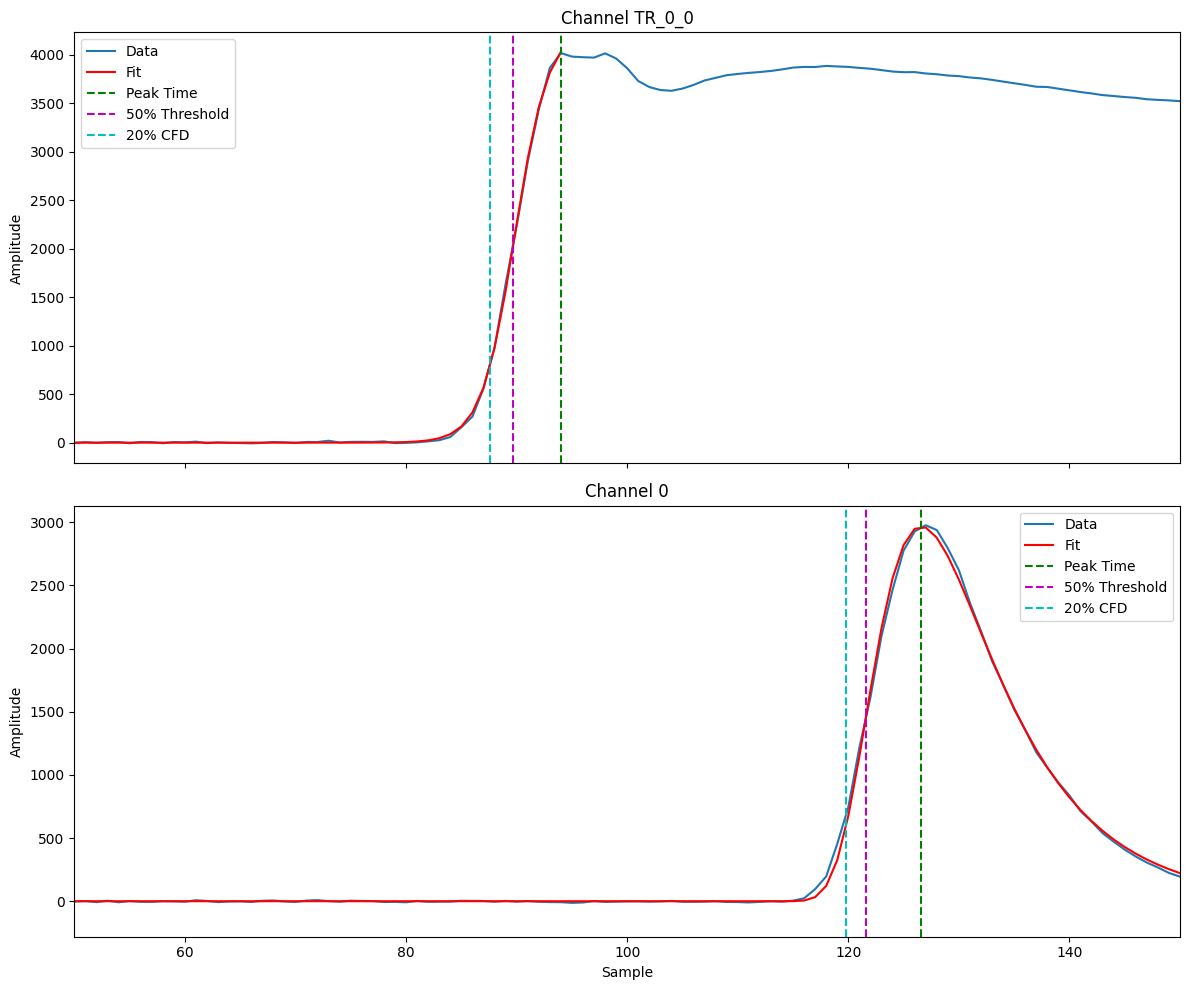

In [90]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import ast

def landau_func(x, loc, scale, amp):
    z = (x - loc) / scale
    return amp * np.exp(-0.5 * (z + np.exp(-z))) / scale

def trigger_func(x, a, b, c, k):
    return a / (1 + np.exp(-k * (x - c))) + b

def find_plateau_start(waveform, threshold=0.01):
    peak_index = np.argmax(waveform)
    for i in range(peak_index, 0, -1):
        if waveform[i] < waveform[peak_index] * (1 - threshold):
            return i + 1
    return 0

def plot_waveforms_with_fit(df, channels):
    n_channels = len(channels)
    fig, axs = plt.subplots(n_channels, 1, figsize=(12, 5*n_channels), sharex=True)
    if n_channels == 1:
        axs = [axs]

    for i, channel in enumerate(channels):
        column_name = f'Samples.Ch{channel}'
        if column_name not in df.columns:
            print(f"Channel {channel} not found in DataFrame")
            continue

        waveform_raw = df[column_name].dropna().iloc[20]
        try:
            waveform = np.array(ast.literal_eval(waveform_raw))
        except:
            waveform = np.array(waveform_raw)

        x = np.arange(len(waveform))

        peak_index = np.argmax(waveform)

        if channel == 'TR_0_0':
            plateau_start = find_plateau_start(waveform)
            fit_range = slice(0, plateau_start + 1)
        elif channel == '1':
            fit_start = max(0, peak_index - 10)
            fit_range = slice(fit_start, peak_index + 5)
        else:
            fit_range = slice(50, 200)

        x_masked = x[fit_range]
        data_masked = waveform[fit_range]

        try:
            if channel == 'TR_0_0':
                rise_start = np.argmax(data_masked > np.min(data_masked) + 0.1 * (np.max(data_masked) - np.min(data_masked)))
                p0 = [np.max(data_masked) - np.min(data_masked),
                      np.min(data_masked),
                      rise_start,
                      1]
                bounds = ([0, -np.inf, 0, 0], 
                          [np.inf, np.inf, len(x_masked), 100])
                popt, _ = curve_fit(trigger_func, x_masked, data_masked, p0=p0, bounds=bounds, maxfev=10000)
                y_fit = trigger_func(x[:plateau_start + 1], *popt)
            else:
                if channel == '1':
                    p0 = [peak_index, (x_masked[-1] - x_masked[0]) / 10, np.max(data_masked)]
                    bounds = ([fit_start, 0, 0], [len(x_masked) + fit_start, len(x_masked), np.inf])
                else:
                    p0 = [np.mean(x_masked), (x_masked[-1] - x_masked[0]) / 10, np.max(data_masked)]
                    bounds = ([x_masked[0], 0, 0], [x_masked[-1], x_masked[-1] - x_masked[0], np.inf])
                popt, _ = curve_fit(landau_func, x_masked, data_masked, p0=p0, bounds=bounds, maxfev=10000)
                y_fit = landau_func(x, *popt)

            axs[i].plot(x, waveform, label='Data')
            if channel == 'TR_0_0':
                axs[i].plot(x[:plateau_start + 1], y_fit, 'r-', label='Fit')
            else:
                axs[i].plot(x, y_fit, 'r-', label='Fit')
            axs[i].set_title(f'Channel {channel}')
            axs[i].set_ylabel('Amplitude')
            

            if channel == 'TR_0_0':
                peak_time = plateau_start
                half_max = (np.max(y_fit) + np.min(y_fit)) / 2
                threshold_time = np.interp(half_max, y_fit, x[:plateau_start + 1])
                cfd_level = np.max(y_fit) * 0.2 + np.min(y_fit) * 0.8
                cfd_time = np.interp(cfd_level, y_fit, x[:plateau_start + 1])
            else:
                peak_time = popt[0]
                half_max = (np.max(y_fit) + np.min(y_fit)) / 2
                threshold_time = np.interp(half_max, y_fit[:int(peak_time)], x[:int(peak_time)])
                cfd_level = np.max(y_fit) * 0.2 + np.min(y_fit) * 0.8
                cfd_time = np.interp(cfd_level, y_fit[:int(peak_time)], x[:int(peak_time)])

            axs[i].axvline(peak_time, color='g', linestyle='--', label='Peak Time')
            axs[i].axvline(threshold_time, color='m', linestyle='--', label='50% Threshold')
            axs[i].axvline(cfd_time, color='c', linestyle='--', label='20% CFD')
            axs[i].legend()

        except Exception as e:
            print(f"Fitting failed for channel {channel}: {str(e)}")
            axs[i].plot(x, waveform, label='Data')
            axs[i].set_title(f'Channel {channel} (Fit Failed)')

    axs[-1].set_xlabel('Sample')
    plt.tight_layout()
    plt.xlim(50,150)
    plt.show()

# Use this function
plot_waveforms_with_fit(df_merged, channels=['TR_0_0', '0'])

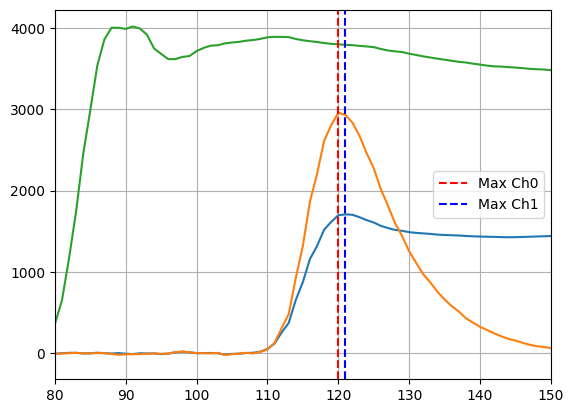

In [60]:
j = 120

plt.plot(df['Samples.Ch1'][j])
plt.plot(df['Samples.Ch0'][j])
plt.plot(df['Samples.ChTR_0_0'][j])
max0 = np.argmax(df['Samples.Ch0'][j])
max1 = np.argmax(df['Samples.Ch1'][j])

plt.axvline(x=max0, color='r', linestyle='--', label='Max Ch0')
plt.axvline(x=max1, color='b', linestyle='--', label='Max Ch1')
plt.legend()
plt.xlim(80,150)
plt.grid()

In [91]:
from multiprocessing import Pool
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def landau_func(x, loc, scale, amp):
    z = (x - loc) / scale
    return amp * np.exp(-0.5 * (z + np.exp(-z))) / scale

def trigger_func(x, a, b, c, k):
    return a / (1 + np.exp(-k * (x - c))) + b

def find_plateau_start(waveform, threshold=0.01):
    peak_index = np.argmax(waveform)
    for i in range(peak_index, 0, -1):
        if waveform[i] < waveform[peak_index] * (1 - threshold):
            return i + 1
    return 0

def analyze_waveform(waveform, channel):
    waveform = np.array(waveform)
    x = np.arange(len(waveform))
    peak_index = np.argmax(waveform)

    if channel == 'TR_0_0':
        plateau_start = find_plateau_start(waveform)
        fit_range = slice(0, plateau_start + 1)
        x_masked = x[fit_range]
        data_masked = waveform[fit_range]

        rise_start = np.argmax(data_masked > np.min(data_masked) + 0.1 * (np.max(data_masked) - np.min(data_masked)))
        p0 = [np.max(data_masked) - np.min(data_masked),
              np.min(data_masked),
              rise_start,
              1]
        bounds = ([0, -np.inf, 0, 0], 
                  [np.inf, np.inf, len(x_masked), 100])
        
        try:
            popt, _ = curve_fit(trigger_func, x_masked, data_masked, p0=p0, bounds=bounds, maxfev=10000)
            y_fit = trigger_func(x[:plateau_start + 1], *popt)
            
            peak_time = plateau_start
            half_max = (np.max(y_fit) + np.min(y_fit)) / 2
            threshold_time = np.interp(half_max, y_fit, x[:plateau_start + 1])
            cfd_level = np.max(y_fit) * 0.2 + np.min(y_fit) * 0.8
            cfd_time_simple = np.interp(cfd_level, y_fit, x[:plateau_start + 1])
            
            # Analog CFD for trigger
            delayed = np.roll(y_fit, 2)
            cfd_signal = delayed - 0.2 * y_fit
            zero_cross_index = np.argmax(cfd_signal[2:] > 0) + 2
            cfd_time_analog = np.interp(0, [cfd_signal[zero_cross_index-1], cfd_signal[zero_cross_index]], 
                                        [x[zero_cross_index-1], x[zero_cross_index]])
        except:
            print(f"Fitting failed for trigger channel - returning None")
            return pd.Series({'peak_time': None, 'threshold_time': None, 'cfd_time_simple': None, 'cfd_time_analog': None})

    else:
        x_range = (50, 200)
        mask = (x >= x_range[0]) & (x <= x_range[1])
        x_masked = x[mask]
        data_masked = waveform[mask]

        p0 = [x_masked[np.argmax(data_masked)], (x_masked[-1] - x_masked[0]) / 10, np.max(data_masked)]
        bounds = ([x_masked[0], 0, 0], [x_masked[-1], x_masked[-1] - x_masked[0], np.inf])

        try:
            popt, _ = curve_fit(landau_func, x_masked, data_masked, p0=p0, bounds=bounds, maxfev=10000)
            y_fit = landau_func(x, *popt)

            peak_time = popt[0]
            half_max = y_fit.max() / 2
            threshold_time = np.interp(half_max, y_fit[:int(peak_time)], x[:int(peak_time)])
            cfd_level = y_fit.max() * 0.2
            cfd_index = np.argmax(y_fit > cfd_level)
            cfd_time_simple = np.interp(cfd_level, [y_fit[cfd_index-1], y_fit[cfd_index]], [x[cfd_index-1], x[cfd_index]])

            # Analog CFD
            delayed = np.roll(y_fit, 2)
            cfd_signal = delayed - 0.2 * y_fit
            zero_cross_index = np.argmax(cfd_signal[2:] > 0) + 2
            cfd_time_analog = np.interp(0, [cfd_signal[zero_cross_index-1], cfd_signal[zero_cross_index]], 
                                        [x[zero_cross_index-1], x[zero_cross_index]])
        except:
            print(f"Fitting failed for channel {channel} - returning None")
            return pd.Series({'peak_time': None, 'threshold_time': None, 'cfd_time_simple': None, 'cfd_time_analog': None})

    return pd.Series({
        'peak_time': peak_time,
        'threshold_time': threshold_time,
        'cfd_time_simple': cfd_time_simple,
        'cfd_time_analog': cfd_time_analog
    })

def process_waveform(args):
    waveform, channel = args
    return analyze_waveform(waveform, channel)

def process_channel(args):
    df, channel = args
    column_name = f'Samples.Ch{channel}'
    
    if column_name not in df.columns:
        return pd.DataFrame()  # Return empty DataFrame if channel doesn't exist
    
    results = df[column_name].apply(lambda x: process_waveform((x, channel)))
    results.columns = [f'{col}.Ch{channel}' for col in results.columns]
    
    return results

def parallel_process_channels(df, channels, num_processes=8):
    with Pool(num_processes) as pool:
        results = pool.map(process_channel, [(df, channel) for channel in channels])
    return pd.concat(results, axis=1)

# Usage
channels = ['TR_0_0', '0']  # Include TR_0_0 and any other channels
num_processes = 8  # Adjust based on your CPU cores

# Process all channels in parallel
results = parallel_process_channels(df_merged, channels, num_processes)

# Add the results to your original DataFrame
df = pd.concat([df_merged, results], axis=1)

# Now df contains timing information for all channels

In [92]:
df

,Samples.ChTR_0_0,Background.ChTR_0_0,Max_value.ChTR_0_0,Integral.ChTR_0_0,Samples.Ch0,Background.Ch0,Max_value.Ch0,Integral.Ch0,Samples.Ch1,Background.Ch1,Max_value.Ch1,Integral.Ch1,peak_time.ChTR_0_0,threshold_time.ChTR_0_0,cfd_time_simple.ChTR_0_0,cfd_time_analog.ChTR_0_0,peak_time.Ch0,threshold_time.Ch0,cfd_time_simple.Ch0,cfd_time_analog.Ch0
0,"[12.759200033333343, 12.710967033333347, 1.677...",82.240800,4036.853438,3.309135e+06,"[4.488448000000005, 4.501600999999994, 7.47028...",274.511552,2876.500655,44884.668378,"[-4.467676766666727, -4.45891776666673, -2.449...",398.467677,1677.217137,522120.598043,76.0,71.597471,69.537070,64.050552,108.537982,103.546309,101.651251,102.049199
1,"[-1.170934566666645, -1.170934566666645, 6.763...",77.170935,4085.663538,3.243243e+06,"[-4.399592066666685, -4.399592066666685, -1.42...",267.399592,2907.222967,45032.703237,"[-0.9331207666666614, -0.9331207666666614, 3.0...",389.933121,1694.406234,521129.676151,97.0,91.609387,89.528328,83.122428,128.279221,123.332890,121.443790,121.815847
2,"[0.6959605666666704, 0.6959605666666704, -1.28...",69.304039,4049.749184,3.317533e+06,"[-3.040932166666664, -3.040932166666664, 5.859...",266.040932,2926.849937,45736.199846,"[1.5102670333333776, 1.5102670333333776, -0.46...",388.489733,1701.425550,530971.805672,75.0,70.810766,68.708681,1.000000,107.564400,102.575542,100.682862,101.067359
3,"[3.5373822666666825, 3.5373822666666825, -9.39...",70.462618,4014.042997,3.236783e+06,"[-5.217538966666666, -5.217538966666666, -3.22...",265.217539,2952.370107,46030.920837,"[-1.7721537666666904, -1.7721537666666904, 2.2...",385.772154,1728.399233,537273.299887,99.0,94.957323,92.872882,86.073937,131.788031,126.818375,124.961655,125.233114
4,"[-10.131768866666661, -10.122891866666663, -7....",66.131769,4022.572577,3.298312e+06,"[3.246589133333316, 3.25547013333329, 6.174781...",264.753411,2989.594489,46259.544648,"[2.69859009999999, 2.701550099999963, 3.639844...",385.301410,1731.745953,541229.767094,82.0,77.045877,75.056009,67.453186,113.901455,108.954203,107.096041,107.356453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41937,"[-5.989455633333321, -5.989455633333321, 0.931...",66.989456,4017.736618,3.259808e+06,"[-7.289696699999979, -7.289696699999979, 4.574...",260.289697,2963.896826,46464.910788,"[-2.0634196000000316, -2.0634196000000316, 1.8...",385.063420,1723.347957,537741.871667,93.0,88.481058,86.389265,1.000000,125.362880,120.382085,118.482508,118.844363
41938,"[0.2751169999999945, 0.21469999999999345, -6.5...",72.724883,4014.650361,3.316852e+06,"[-5.310496100000023, -5.345011100000022, -9.09...",265.310496,2947.830861,45431.018541,"[-5.729363033333357, -5.712090033333368, -3.64...",387.729363,1712.055549,535004.741150,76.0,71.110527,69.084106,63.888567,107.913946,102.982738,101.125854,101.397484
41939,"[8.526588633333347, 8.524696633333349, 4.52658...",77.473411,4052.831765,3.246408e+06,"[2.125365233333355, 2.1248772333333363, 1.1216...",266.874635,2923.267943,45612.297316,"[5.443446866666648, 5.442500866666649, 3.43343...",390.556553,1707.441494,527717.776602,95.0,89.972541,87.907327,82.025787,126.702238,121.717987,119.839382,120.154817
41940,"[-0.9316841333333343, -0.9316841333333343, 0.0...",76.931684,4068.003863,3.315715e+06,"[0.6402913666667018, 0.6402913666667018, -5.30...",267.359709,2893.622713,44873.428683,"[-1.8041604333332657, -1.8041604333332657, -0....",389.804160,1682.125283,523876.756552,75.0,70.298683,68.201259,62.648774,107.011507,102.053394,100.177765,100.430306


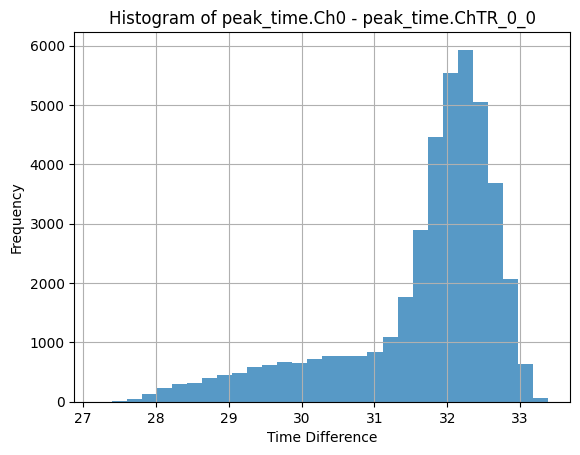

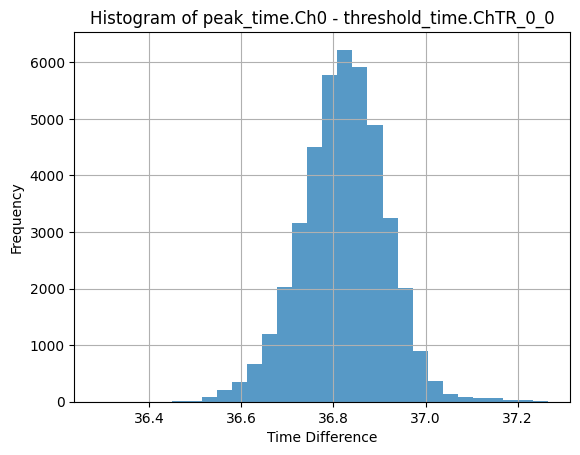

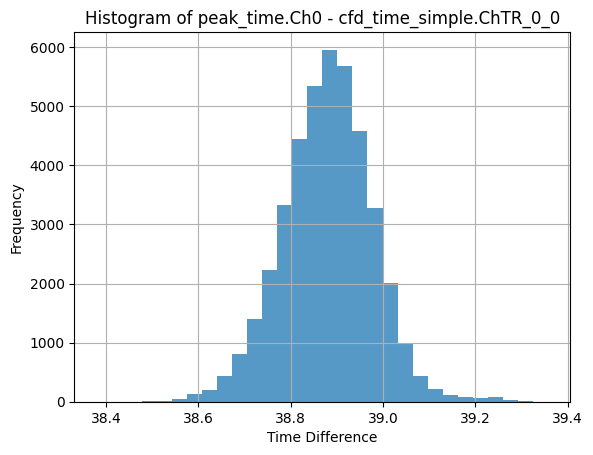

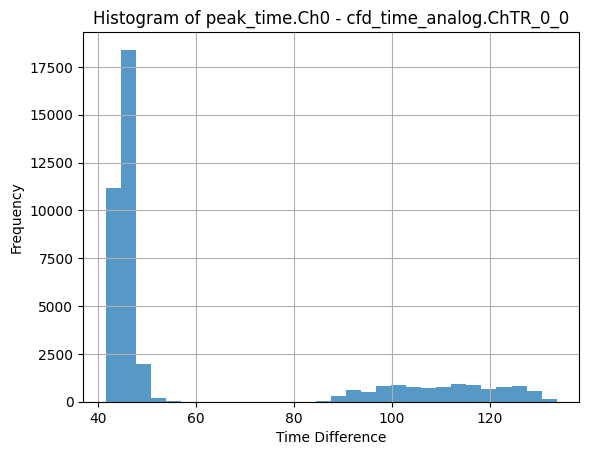

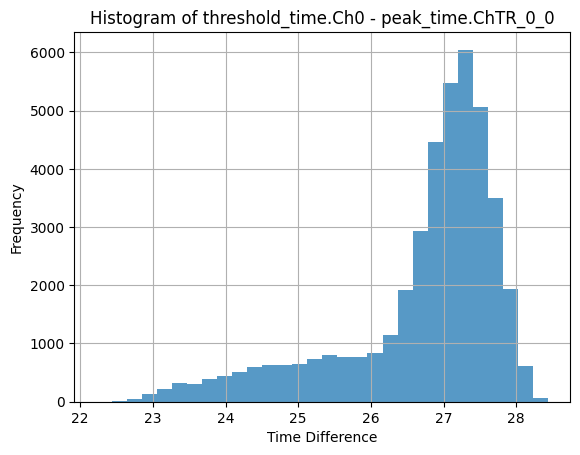

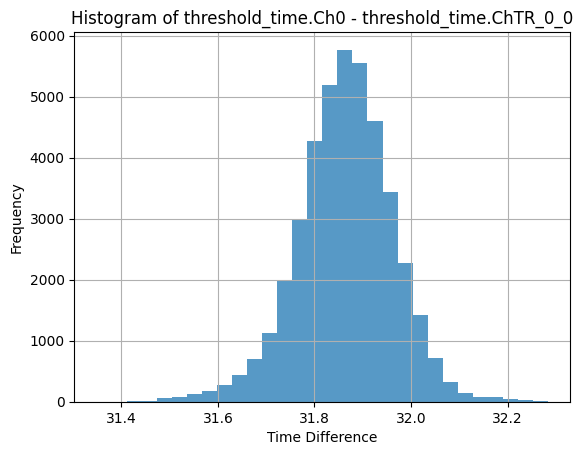

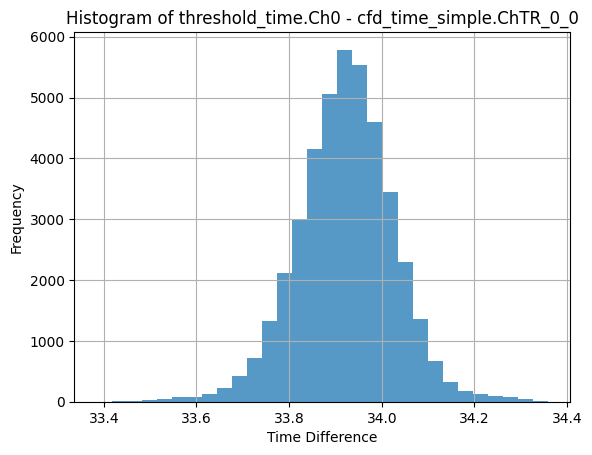

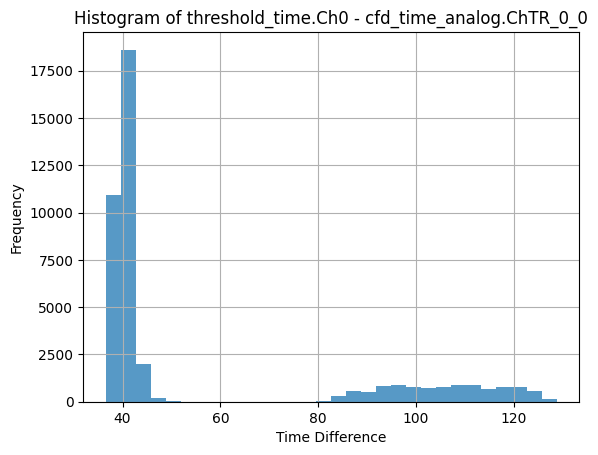

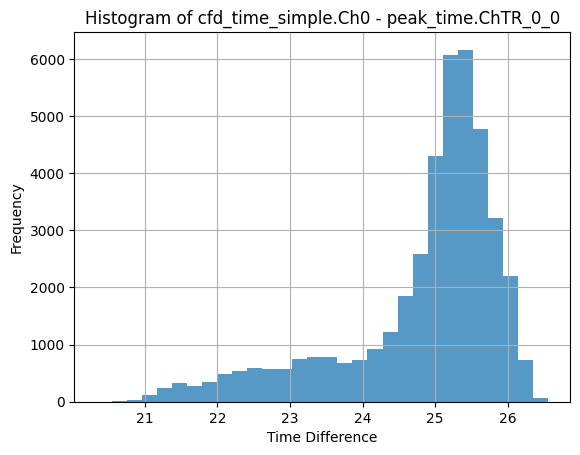

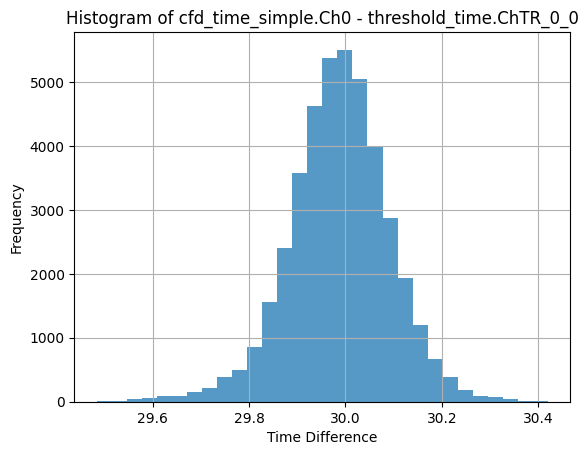

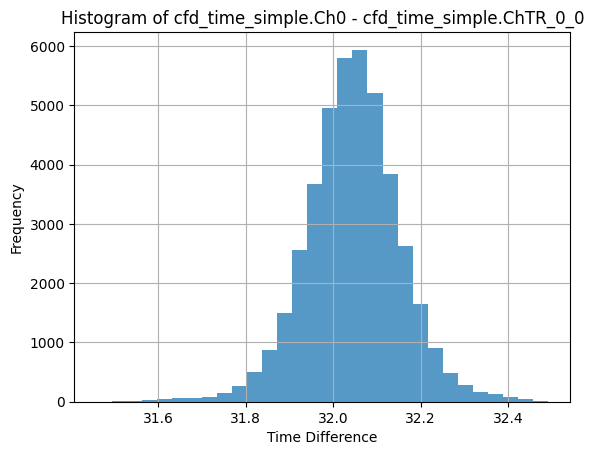

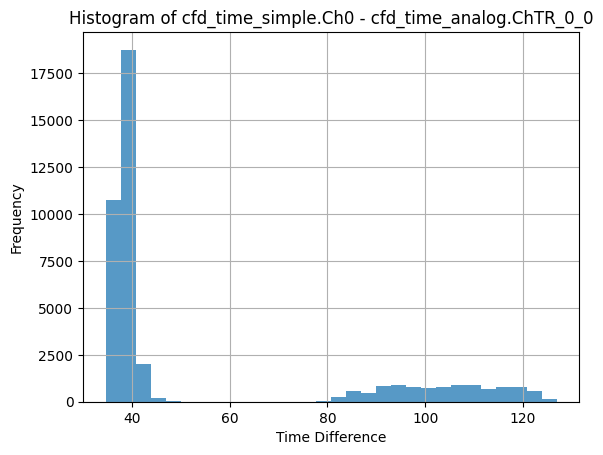

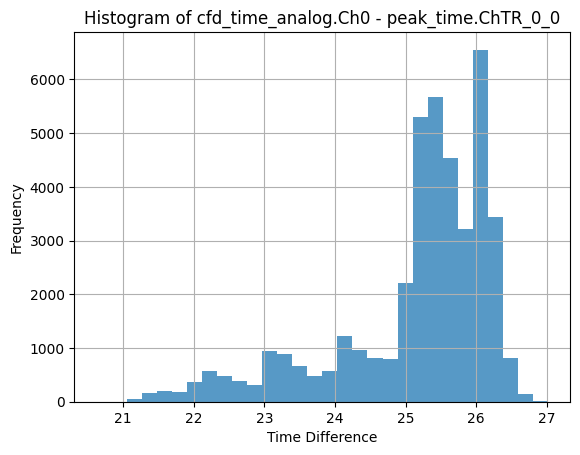

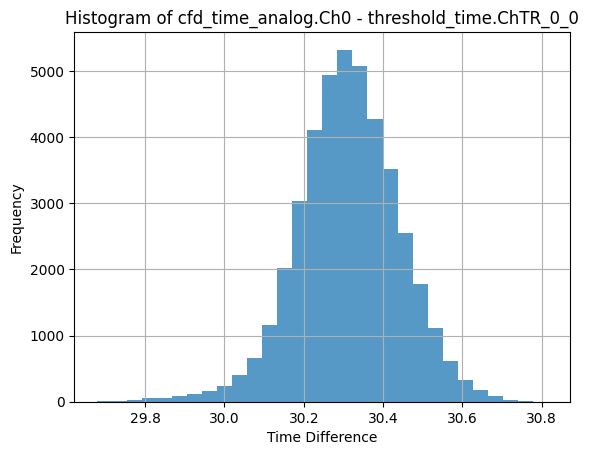

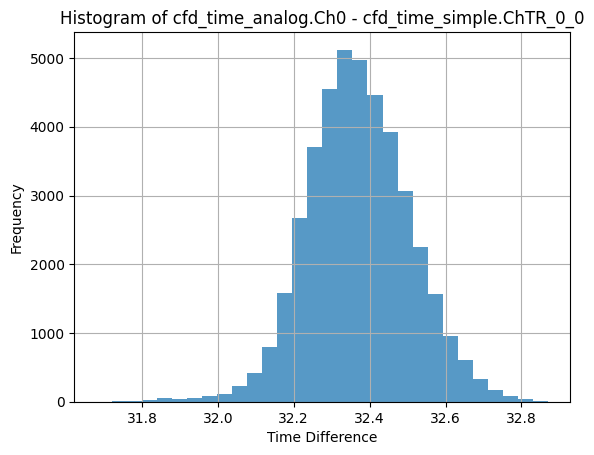

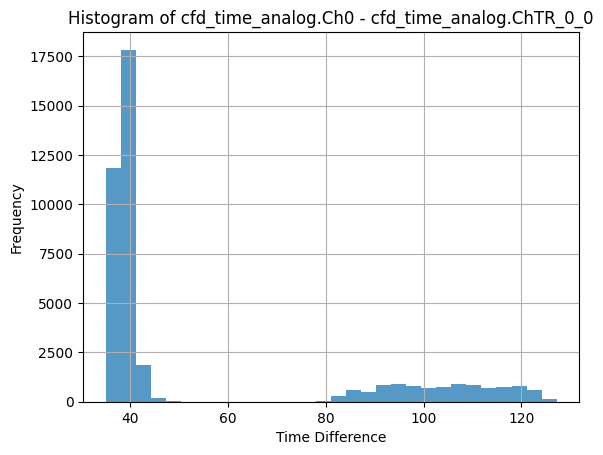

In [109]:
trigger_times = df.filter(like='time').filter(like='TR')
wave_times = df.filter(like='time').filter(like='Ch0')

# Create a list of all combinations of channel and trigger columns
channel_cols = wave_times.columns
trigger_cols = trigger_times.columns

# Calculate time differences and plot histograms
for channel_col in channel_cols:
    for trigger_col in trigger_cols:
        time_diff = wave_times[channel_col] - trigger_times[trigger_col]
        
        plt.figure()
        plt.hist(time_diff.dropna(), bins=30, alpha=0.75)
        plt.title(f'Histogram of {channel_col} - {trigger_col}')
        plt.xlabel('Time Difference')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

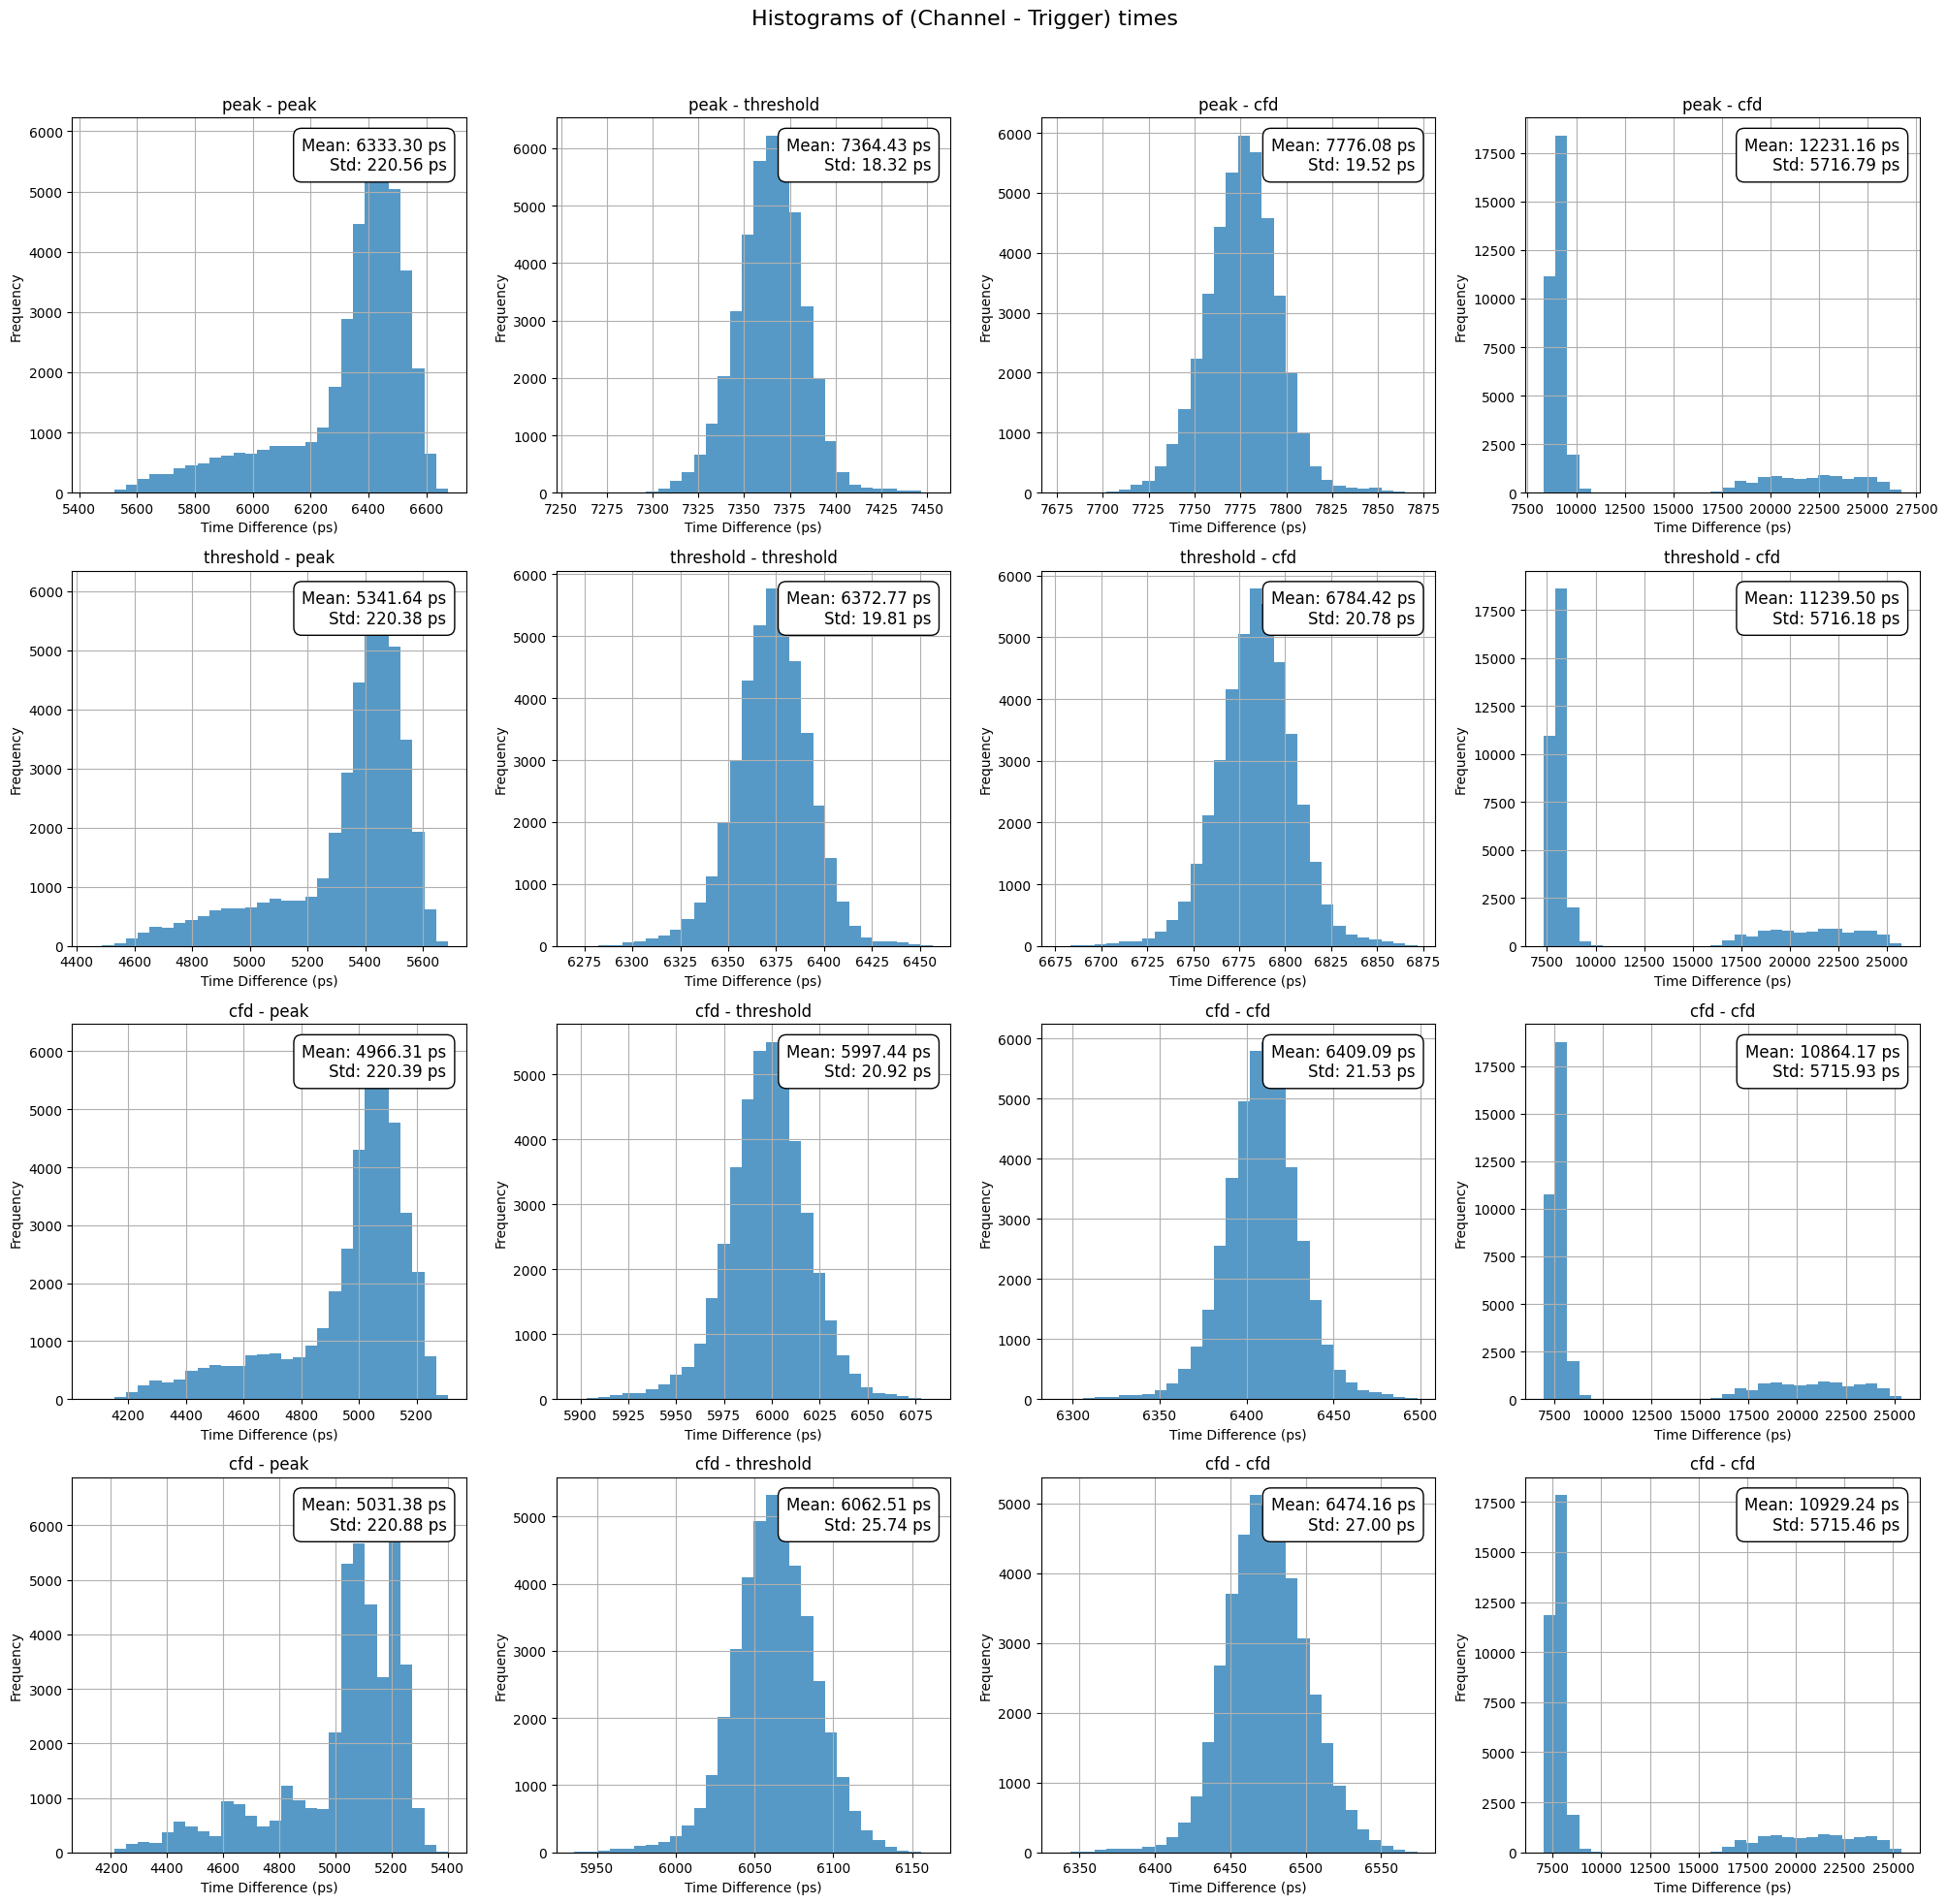

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your original dataframe
# Separate the dataframes
trigger_df = df.filter(like='time').filter(like='TR')
channel_df = df.filter(like='time').filter(like='Ch0')


# Create a list of all combinations of channel and trigger columns
channel_cols = channel_df.columns
trigger_cols = trigger_df.columns

# Convert time difference to picoseconds (ps)
time_conversion_factor = 200  # 200ps per sample

# Create a figure with a large canvas
fig, axes = plt.subplots(len(channel_cols), len(trigger_cols), figsize=(20, 20))
fig.suptitle('Histograms of (Channel - Trigger) times', fontsize=16)

for i, channel_col in enumerate(channel_cols):
    for j, trigger_col in enumerate(trigger_cols):
        time_diff = (channel_df[channel_col] - trigger_df[trigger_col]) * time_conversion_factor
        
        # Calculate mean and std
        mean_diff = time_diff.mean()
        std_diff = time_diff.std()
        
        # Plot histogram
        ax = axes[i, j]
        ax.hist(time_diff.dropna(), bins=30, alpha=0.75)
        ax.set_title(f'{channel_col.split("_")[0]} - {trigger_col.split("_")[0]}')
        ax.set_xlabel('Time Difference (ps)')
        ax.set_ylabel('Frequency')
        ax.grid(True)
        
        # Annotate mean and std on the plot
        textstr = f'Mean: {mean_diff:.2f} ps\nStd: {std_diff:.2f} ps'
        ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
                fontsize=12, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [123]:
df

,Samples.ChTR_0_0,Background.ChTR_0_0,Max_value.ChTR_0_0,Integral.ChTR_0_0,Samples.Ch0,Background.Ch0,Max_value.Ch0,Integral.Ch0,Samples.Ch1,Background.Ch1,Max_value.Ch1,Integral.Ch1,peak_time.ChTR_0_0,threshold_time.ChTR_0_0,cfd_time_simple.ChTR_0_0,cfd_time_analog.ChTR_0_0,peak_time.Ch0,threshold_time.Ch0,cfd_time_simple.Ch0,cfd_time_analog.Ch0
0,"[12.759200033333343, 12.710967033333347, 1.677...",82.240800,4036.853438,3.309135e+06,"[4.488448000000005, 4.501600999999994, 7.47028...",274.511552,2876.500655,44884.668378,"[-4.467676766666727, -4.45891776666673, -2.449...",398.467677,1677.217137,522120.598043,76.0,71.597471,69.537070,64.050552,108.537982,103.546309,101.651251,102.049199
1,"[-1.170934566666645, -1.170934566666645, 6.763...",77.170935,4085.663538,3.243243e+06,"[-4.399592066666685, -4.399592066666685, -1.42...",267.399592,2907.222967,45032.703237,"[-0.9331207666666614, -0.9331207666666614, 3.0...",389.933121,1694.406234,521129.676151,97.0,91.609387,89.528328,83.122428,128.279221,123.332890,121.443790,121.815847
2,"[0.6959605666666704, 0.6959605666666704, -1.28...",69.304039,4049.749184,3.317533e+06,"[-3.040932166666664, -3.040932166666664, 5.859...",266.040932,2926.849937,45736.199846,"[1.5102670333333776, 1.5102670333333776, -0.46...",388.489733,1701.425550,530971.805672,75.0,70.810766,68.708681,1.000000,107.564400,102.575542,100.682862,101.067359
3,"[3.5373822666666825, 3.5373822666666825, -9.39...",70.462618,4014.042997,3.236783e+06,"[-5.217538966666666, -5.217538966666666, -3.22...",265.217539,2952.370107,46030.920837,"[-1.7721537666666904, -1.7721537666666904, 2.2...",385.772154,1728.399233,537273.299887,99.0,94.957323,92.872882,86.073937,131.788031,126.818375,124.961655,125.233114
4,"[-10.131768866666661, -10.122891866666663, -7....",66.131769,4022.572577,3.298312e+06,"[3.246589133333316, 3.25547013333329, 6.174781...",264.753411,2989.594489,46259.544648,"[2.69859009999999, 2.701550099999963, 3.639844...",385.301410,1731.745953,541229.767094,82.0,77.045877,75.056009,67.453186,113.901455,108.954203,107.096041,107.356453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41937,"[-5.989455633333321, -5.989455633333321, 0.931...",66.989456,4017.736618,3.259808e+06,"[-7.289696699999979, -7.289696699999979, 4.574...",260.289697,2963.896826,46464.910788,"[-2.0634196000000316, -2.0634196000000316, 1.8...",385.063420,1723.347957,537741.871667,93.0,88.481058,86.389265,1.000000,125.362880,120.382085,118.482508,118.844363
41938,"[0.2751169999999945, 0.21469999999999345, -6.5...",72.724883,4014.650361,3.316852e+06,"[-5.310496100000023, -5.345011100000022, -9.09...",265.310496,2947.830861,45431.018541,"[-5.729363033333357, -5.712090033333368, -3.64...",387.729363,1712.055549,535004.741150,76.0,71.110527,69.084106,63.888567,107.913946,102.982738,101.125854,101.397484
41939,"[8.526588633333347, 8.524696633333349, 4.52658...",77.473411,4052.831765,3.246408e+06,"[2.125365233333355, 2.1248772333333363, 1.1216...",266.874635,2923.267943,45612.297316,"[5.443446866666648, 5.442500866666649, 3.43343...",390.556553,1707.441494,527717.776602,95.0,89.972541,87.907327,82.025787,126.702238,121.717987,119.839382,120.154817
41940,"[-0.9316841333333343, -0.9316841333333343, 0.0...",76.931684,4068.003863,3.315715e+06,"[0.6402913666667018, 0.6402913666667018, -5.30...",267.359709,2893.622713,44873.428683,"[-1.8041604333332657, -1.8041604333332657, -0....",389.804160,1682.125283,523876.756552,75.0,70.298683,68.201259,62.648774,107.011507,102.053394,100.177765,100.430306


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([36.28638507, 36.29617715, 36.30596922, 36.31576129, 36.32555337,
        36.33534544, 36.34513751, 36.35492959, 36.36472166, 36.37451373,
        36.38430581, 36.39409788, 36.40388995, 36.41368203, 36.4234741 ,
        36.43326617, 36.44305825, 36.45285032, 36.46264239, 36.47243447,
        36.48222654, 36.49201861, 36.50181069, 36.51160276, 36.52139483,
        36.53118691, 36.54097898, 36.55077105, 36.56056313, 36.5703552 ,
        36.58014727, 36.58993935, 36.59973142, 36.60952349, 36.61931557,
        36.62910764, 36.63889971, 36.64869179, 36.65848386, 36.66827594,
        36.67806801, 36.68786008, 36.69765216, 36.70744423, 36.7172363 ,
        36.72702838, 36.73682045, 36.74661252, 36.7564046 , 36.76619667,
        36.77598874, 

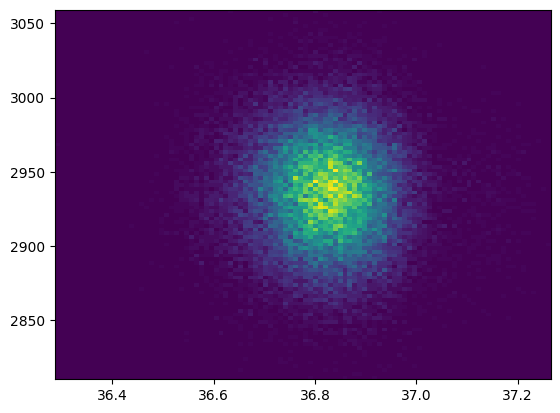

In [130]:
plt.hist2d(df['peak_time.Ch0']-df['threshold_time.ChTR_0_0'], df['Max_value.Ch0'], 100)